In [1]:

import numpy as np
from clawpack import riemann
from clawpack.riemann.shallow_roe_with_efix_1D_constants import depth, momentum, num_eqn
import logging
import numpy as np
from clawpack import riemann

def setup(use_petsc=0,kernel_language='Fortran',outdir='./_output',solver_type='classic'):
    logger = logging.getLogger('pyclaw')
    logger.setLevel(logging.CRITICAL)
    if use_petsc:
        import clawpack.petclaw as pyclaw
    else:
        from clawpack import pyclaw

    riemann_solver = riemann.shallow_roe_with_efix_2D

    solver = pyclaw.ClawSolver2D(riemann_solver)
    solver.limiters = pyclaw.limiters.tvd.minmod

    solver.kernel_language = kernel_language
    
    # Can use different BCs to stress test the CFN
    solver.bc_lower[0] = pyclaw.BC.periodic
    solver.bc_upper[0] = pyclaw.BC.periodic
    solver.bc_lower[1] = pyclaw.BC.periodic
    solver.bc_upper[1] = pyclaw.BC.periodic

    xlower = 0
    xupper = 1
    mx = 256
    x = pyclaw.Dimension(xlower, xupper, mx, name='x')
    
    ylower = 0
    yupper = 1
    my = 256
    y = pyclaw.Dimension(ylower, yupper, my, name='y')
    
    domain = pyclaw.Domain([x, y])
    
    num_eqn = 3
    state = pyclaw.State(domain, num_eqn)
    
    state.problem_data['grav'] = 1.0

    xc, yc = state.grid.p_centers
    x_xi = np.random.uniform(-0.1, 0.1)
    y_xi = np.random.uniform(-0.1, 0.1)
    x_center = 0.5 + x_xi
    y_center = 0.5 + y_xi
    r = np.sqrt((xc - x_center)**2 + (yc - y_center)**2)
    r0 = 0.1
    
    # h = 2.0 inside circle, 1.0 outside
    state.q[0, :, :] = 1.0 + 1.0 * (r < r0) 
    
    # Initial momentum is zero
    state.q[1, :, :] = 0.0
    state.q[2, :, :] = 0.0

    claw = pyclaw.Controller()
    claw.tfinal = 0.005*20
    claw.num_output_times = 20
    claw.output_format = None
    claw.solution = pyclaw.Solution(state, domain)
    claw.solver = solver
    claw.outdir = outdir
    claw.setplot = setplot
    claw.keep_copy = True

    return claw


def setplot(plotdata):
    """ 
    Plot solution using VisClaw.
    """ 
    plotdata.clearfigures()  # clear any old figures,axes,items data

    # Figure for q[0]
    plotfigure = plotdata.new_plotfigure(name='Water Depth', figno=0)

    # Set up for axes in this figure:
    plotaxes = plotfigure.new_plotaxes()
    plotaxes.title = 'Depth (h)'
    plotaxes.scaled = True

    # Set up for item on these axes:
    plotitem = plotaxes.new_plotitem(plot_type='2d_pcolor')
    plotitem.pcolor_cmap = 'Blues'
    plotitem.pcolor_cmin = 0.8
    plotitem.pcolor_cmax = 2.2
    plotitem.add_colorbar = True
    
    return plotdata


# np.random.seed(51349) # eval
np.random.seed(0) # train
# np.random.seed(123456789) # test
from clawpack.pyclaw.util import run_app_from_main
sol = []

num_samples = 200
count = 0
while count < num_samples:
    # Access the specific sol[j]
    claw = setup()
    output = claw.run()

    # Check if any frame has NaN or inf in q
    has_nan = any(np.isnan(frame.q).any() for frame in claw.frames)
    has_inf = any(np.isinf(frame.q).any() for frame in claw.frames)

    # If no NaN/inf is found, add to the valid list and increase the count
    if not has_nan and not has_inf:
        sol.append([claw.frames[i].q for i in range(len(claw.frames))])
        count += 1
    else:
        print("Has NaN/Inf, retry...")


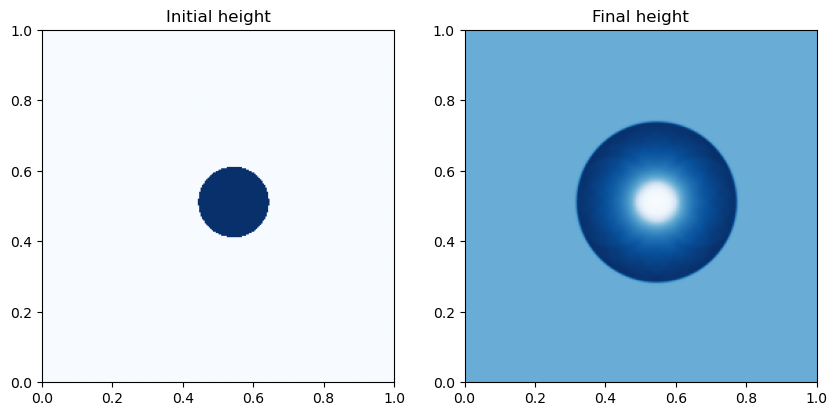

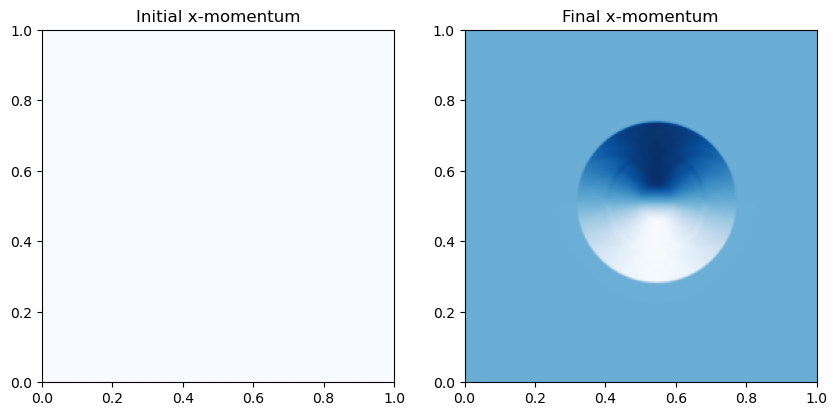

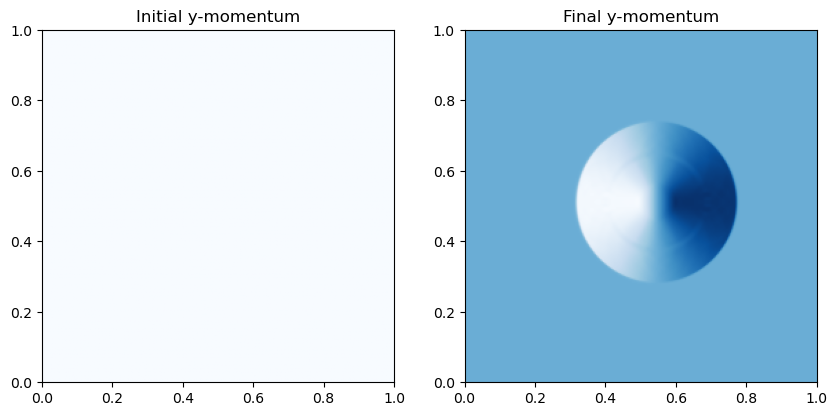

In [2]:
import matplotlib.pyplot as plt
# Cell 1 stores each trajectory as a list of q arrays (not Solution/Frame objects).
# Each q has shape (num_eqn, mx, my); for 2D shallow water: (3, mx, my).
x_start = 0
x_end = 1
y_start = 0
y_end = 1

t0 = sol[0][0][0, :, :]
tfinal = sol[0][-1][0, :, :]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot Initial State
ax[0].imshow(t0, origin='lower', extent=[x_start, x_end, y_start, y_end], cmap='Blues')
ax[0].set_title("Initial height")

# Plot Final State
ax[1].imshow(tfinal, origin='lower', extent=[x_start, x_end, y_start, y_end], cmap='Blues')
ax[1].set_title("Final height")

plt.show()

t0 = sol[0][0][1, :, :]
tfinal = sol[0][-1][1, :, :]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot Initial State
ax[0].imshow(t0, origin='lower', extent=[x_start, x_end, y_start, y_end], cmap='Blues')
ax[0].set_title("Initial x-momentum")

# Plot Final State
ax[1].imshow(tfinal, origin='lower', extent=[x_start, x_end, y_start, y_end], cmap='Blues')
ax[1].set_title("Final x-momentum")

plt.show()

t0 = sol[0][0][2, :, :]
tfinal = sol[0][-1][2, :, :]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot Initial State
ax[0].imshow(t0, origin='lower', extent=[x_start, x_end, y_start, y_end], cmap='Blues')
ax[0].set_title("Initial y-momentum")

# Plot Final State
ax[1].imshow(tfinal, origin='lower', extent=[x_start, x_end, y_start, y_end], cmap='Blues')
ax[1].set_title("Final y-momentum")

plt.show()

In [3]:
# Inspect a single saved frame (q array) from the first trajectory.
q1 = sol[0][1]  # q at output time index 1
print('q1 type:', type(q1))
print('q1 shape:', np.asarray(q1).shape)
print('q1 stats: min/max/mean =', float(np.min(q1)), float(np.max(q1)), float(np.mean(q1)))

q1 type: <class 'numpy.ndarray'>
q1 shape: (3, 256, 256)
q1 stats: min/max/mean = -0.6362607177640062 2.0 0.3438212076822917


In [4]:
# Stack into a single array: (n_traj, n_frames, num_eqn, mx, my)
# (num of simulations, num of timesteps, num of variables, num of x grid points, num of y grid points)
# For 2D shallow water: solving for h, hu, and hv
# where h is height, u is x-velocity, v is y-velocity
Data = np.stack([np.stack(traj, axis=0) for traj in sol], axis=0)
print('Data shape:', Data.shape)

Data shape: (200, 21, 3, 256, 256)


In [5]:
import os
os.makedirs('Data', exist_ok=True)
Data_out = np.moveaxis(Data, 2, -1)  # (n_traj, n_frames, mx, my, num_eqn)
np.save('Data/trainData_2D_shallow_water_256.npy', Data_out)
print('Saved:', 'Data/trainData_2D_shallow_water_256.npy', 'with shape', Data_out.shape)

Saved: Data/trainData_2D_shallow_water_256.npy with shape (200, 21, 256, 256, 3)


In [6]:
# Confirm shapes match training code expectation
print('Data (raw) shape:', Data.shape)
print('Data (saved) shape:', Data_out.shape)

Data (raw) shape: (200, 21, 3, 256, 256)
Data (saved) shape: (200, 21, 256, 256, 3)


In [7]:
# --- Helpers to generate val/test datasets (without re-running the big train loop) ---
import os
import numpy as np
from clawpack import riemann
import logging

def setup_param(
    mx=256,
    my=256,
    tfinal=0.005*20,
    num_output_times=20,
    x_xi=None,
    y_xi=None,
    kernel_language='Fortran',
    solver_type='classic',
    outdir='./_output',
    use_petsc=0,
    seed=None,
    ):
        
    logger = logging.getLogger('pyclaw')
    logger.setLevel(logging.CRITICAL)
    if use_petsc:
        import clawpack.petclaw as pyclaw
    else:
        from clawpack import pyclaw
        
    if seed is not None:
        np.random.seed(int(seed))

    riemann_solver = riemann.shallow_roe_with_efix_2D

    solver = pyclaw.ClawSolver2D(riemann_solver)
    solver.limiters = pyclaw.limiters.tvd.minmod

    solver.kernel_language = kernel_language
    
    # Can use different BCs to stress test the CFN
    solver.bc_lower[0] = pyclaw.BC.periodic
    solver.bc_upper[0] = pyclaw.BC.periodic
    solver.bc_lower[1] = pyclaw.BC.periodic
    solver.bc_upper[1] = pyclaw.BC.periodic

    xlower = 0
    xupper = 1
    x = pyclaw.Dimension(xlower, xupper, mx, name='x')
    
    ylower = 0
    yupper = 1
    y = pyclaw.Dimension(ylower, yupper, my, name='y')
    
    domain = pyclaw.Domain([x, y])
    
    num_eqn = 3
    state = pyclaw.State(domain, num_eqn)
    
    state.problem_data['grav'] = 1.0

    xc, yc = state.grid.p_centers
    if x_xi is None:
        x_xi = np.random.uniform(-0.1, 0.1)
    if y_xi is None:
        y_xi = np.random.uniform(-0.1, 0.1)
    x_center = 0.5 + x_xi
    y_center = 0.5 + y_xi
    r = np.sqrt((xc - x_center)**2 + (yc - y_center)**2)
    r0 = 0.1
    
    # h = 2.0 inside circle, 1.0 outside
    state.q[0, :, :] = 1.0 + 1.0 * (r < r0) 
    
    # Initial momentum is zero
    state.q[1, :, :] = 0.0
    state.q[2, :, :] = 0.0

    claw = pyclaw.Controller()
    claw.tfinal = tfinal
    claw.num_output_times = num_output_times
    claw.output_format = None
    claw.solution = pyclaw.Solution(state, domain)
    claw.solver = solver
    claw.outdir = outdir
    claw.setplot = setplot
    claw.keep_copy = True

    return claw


def generate_trajectories(n_traj, setup_fn, *, require_finite=True):
    sol = []
    count = 0
    while count < n_traj:
        # Access the specific sol[j]
        claw = setup_fn()
        claw.run()

        # Check if any frame has NaN or inf in q
        has_nan = any(np.isnan(frame.q).any() for frame in claw.frames)
        has_inf = any(np.isinf(frame.q).any() for frame in claw.frames)

        if not has_nan and not has_inf:
            sol.append([claw.frames[i].q for i in range(len(claw.frames))])
            count += 1
        else:
            print("Has NaN/Inf, retry...")
    return sol



def save_dataset(sol_list, path):
    os.makedirs(os.path.dirname(path) or '.', exist_ok=True)
    data = np.stack([np.stack(traj, axis=0) for traj in sol_list], axis=0)  # (S, T, C, N1, N2)
    data_out = np.moveaxis(data, 2, -1)  # (S, T, N1, N2, C)
    np.save(path, data_out)
    print('Saved', path, 'shape', data_out.shape)

In [8]:
# --- Validation set (different seed) ---
np.random.seed(51349)
sol_val = generate_trajectories(
    n_traj=50,
    setup_fn=lambda: setup_param(mx=256, my=256, tfinal=0.005*20, num_output_times=20)
)
save_dataset(sol_val, 'Data/valData_2D_shallow_water_256.npy')

Saved Data/valData_2D_shallow_water_256.npy shape (50, 21, 256, 256, 3)


In [9]:
# --- Test set: fixed location and long rollout (601 frames) ---
x_xi = 0
y_xi = 0
claw_test = setup_param(mx=256, my=256, tfinal=0.005*600, num_output_times=600, x_xi=x_xi, y_xi=y_xi)
claw_test.run()
sol_test = [[claw_test.frames[i].q for i in range(len(claw_test.frames))]]
save_dataset(sol_test, 'Data/testData_2D_shallow_water_256.npy')

Saved Data/testData_2D_shallow_water_256.npy shape (1, 601, 256, 256, 3)
